## Image Segmentation

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from sklearn.cluster import MeanShift
# Required to calculate Dice Similarity Coefficient

from PIL import Image

# Reduce size of original image to reduce computation time
size = (200,200)# change here

#### Function for displaying images

In [2]:
def plot_two_images(figure_title, image1, label1, image2, label2, 
                    cmap1=None, cmap2=None):
    
    fig = plt.figure()
    fig.suptitle(figure_title)

    # Display the first image
    fig.add_subplot(1, 2, 1)
    plt.imshow(image1, cmap = cmap1)
    plt.axis('off')
    plt.title(label1)

    # Display the second image
    fig.add_subplot(1, 2, 2)
    plt.imshow(image2, cmap = cmap2)
    plt.axis('off')
    plt.title(label2)

    plt.show()

#### Function for applying MeanShift algorithm

In [3]:
def apply_meanshift(img):
    
    # TODO: Apply MeanShift to image
    # Consider the following hints as per the lab specification

    # Step 1 - Extract the three RGB colour channels
    arr = np.array(img)
    rgb_r = arr[:,:,2]
    rgb_g = arr[:,:,1]
    rgb_b = arr[:,:,0]
    # Step 2 - Store original image shape to be used later in resizing
    # Combine the three colour channels by flattening each channel
    # Then stack the flattened channels together
    # This gives the "colour_samples"
    colour_samples = []
    colour_samples.append(rgb_b.reshape(1,rgb_b.size)[0].tolist())
    colour_samples.append(rgb_g.reshape(1,rgb_g.size)[0].tolist())
    colour_samples.append(rgb_r.reshape(1,rgb_r.size)[0].tolist()) 
    colour_samples = np.array(colour_samples).T
    # Step 3 - Perform MeanShift clustering
    # For larger images this may take a few minutes to compute
    ms_clf = MeanShift(bin_seeding=True)
    ms_labels = ms_clf.fit_predict(colour_samples)
    # Step 4 - Reshape ms_labels back to the original image shape
    # for displaying the segmentation output
    ms_labels = ms_labels.reshape(rgb_r.shape).T

    return ms_labels

#### Function for applying Watershed algorithm

In [4]:
def apply_watershed(img, threshold=None, plotDistTransform = False):
    
    # TODO: Apply Watershed to image
    # Consider the following hints as per the lab specification
    
    # Step 1 - Convert the image to grayscale and then binary
    # and convert the image to a numpy matrix
    img_grey = img.convert('L')
    if threshold is not None:
        img_grey = img_grey.point(lambda x: 0 if x < threshold else 255, '1')
    img_array = np.array(img_grey).T
    
    # Step 2 - Calculate the distance transform
    # Hint: Use ndi.distance_transform_edt(img_array)
    distance = ndi.distance_transform_edt(img_array)
    
    # Remember to plot distance transform for Task 2
    
    # Step 3 - Generate the Watershed markers
    # Hint: Use the peak_local_max() function from the skimage.feature library
    # to get the local maximum values and then convert them to markers
    # Remember to change the local search region for good segmentation results
    # using ndi.label() (note the markers are the 0th output of this function)
    local_max = peak_local_max(distance, footprint=np.ones((5,5)), labels=img_array)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(local_max.T)] = True
    markers = ndi.label(mask)[0]
    
    # Step 4 - Perform Watershed and store the labels
    # Hint: Use the watershed() function from the skimage.morphology library
    # with three inputs: -distance, markers and your image array as a mask
    ws_labels = watershed(-distance, markers, mask=img_array)
    
    return ws_labels, distance

### Q1. Use the MeanShift algorithm for image segmentation

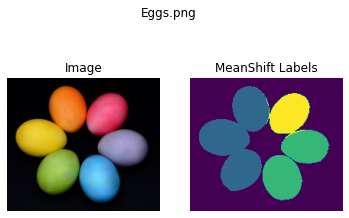

In [5]:
# Specify path to the test image
img_path = 'Eggs.png'

# Read image
img = Image.open(img_path)
img.thumbnail(size)

# Apply MeanShift algorithm to the image
ms_labels = apply_meanshift(img)# change here

# Read and plot the original image and MeanShift result
#img = # change here
ms_labels = ms_labels.tolist()
img_new = Image.new("L",img.size)
for i in range(img.size[0]):
    for j in range(img.size[1]):
        img_new.putpixel((i,j),ms_labels[i][j]*40)

plot_two_images(img_path, img, "Image", img_new, "MeanShift Labels")
ms_labels = np.array(ms_labels)

### Q2. Use Watershed transformation for image segmentation

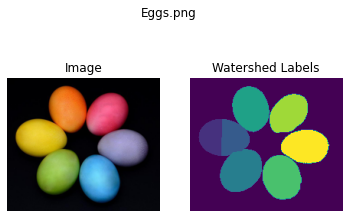

In [6]:
# Read image from img_path as specified above
img = Image.open(img_path)
img.thumbnail(size)
# Apply Watershed algorithm (remember to plot distance transform as well)
ws_labels, distance = apply_watershed(img,threshold=75)# Change here
distance_display = Image.fromarray(distance.T.astype(np.uint8))
for i in range(distance_display.size[0]):
    for j in range(distance_display.size[1]):
        distance_display.putpixel((i,j),int(distance[i,j]*40))
distance_display.show()
distance_display.save('distance.png')

# Read the original image
# change here
plot_two_images(img_path, img, "Image", ws_labels.T, "Watershed Labels")


### Q3. Compare MeanShift and Watershed segmentation results

In [7]:
# List of MaskX.png images
MaskX = ['Mask{}.png'.format(str(idx)) for idx in range(1,7)]

# Generate list of unique MeanShift labels and corresponding label image masks
lbl_ms_unique = np.unique(ms_labels)
ms_masks = ms_labels.copy()
for i in range(ms_labels.shape[0]):
    for j in range(ms_labels.shape[1]):
        if ms_labels[i,j] != 0:
            ms_masks[i,j] = 1
        else:
            ms_masks[i,j] = 0


# Generate list of unique Watershed labels and corresponding label image masks
# Hint: Make sure you have generated reasonable watershed segmentation results
lbl_ws_unique = np.unique(ws_labels)
ws_masks = ws_labels.copy()
for i in range(ws_labels.shape[0]):
    for j in range(ws_labels.shape[1]):
        if ws_labels[i,j] != 0:
            ws_masks[i,j] = 1
        else:
            ws_masks[i,j] = 0

img = Image.open(img_path)
img.thumbnail(size)
img = img.convert('L')
img_binary = img.point(lambda x: 0 if x ==0 else 1)
img_binary2 =  np.array(img_binary).T
# Iterate over MaskX.png images and calculate DSC
d_ms = []
d_ws = []
for each_maskx_image in MaskX:
    # Read each MaskX.png image
    im1 = Image.open(each_maskx_image)
    im1.thumbnail(size)
    im1_binary = im1.point(lambda x: 0 if x ==0 else 1)
    im1_binary2 = np.array(im1_binary).T
    s_ms = []
    s_ws = []
    res_ms = []
    res_ws = []
    origin = []
    for r in range(im1_binary2.shape[0]):
        for c in range(im1_binary2.shape[1]):
            if im1_binary2[r,c] == 1:
                if ms_masks[r,c] == 1 and img_binary2[r,c] == 1:
                    s_ms.append(1)
                if ms_masks[r,c]  == 1:
                    res_ms.append(1)
                if ws_masks[r,c] == 1 and  img_binary2[r,c] == 1:
                    s_ws.append(1)
                if ws_masks[r,c]  == 1:
                    res_ws.append(1)
                if img_binary2[r,c] == 1:
                    origin.append(1)
    m1_ms = len(s_ms)
    m2_ms = len(res_ms) + len(origin)
    d_ms.append(2*m1_ms/m2_ms)
    m1_ws = len(s_ws)
    m2_ws = len(res_ws) + len(origin)
    d_ws.append(2*m1_ws/m2_ws)
print('Meanshift:')
print(d_ms)
print(np.mean(np.array(d_ms)))
print('Watershed:')
print(d_ws)
print(np.mean(np.array(d_ws)))

Meanshift:
[0.9583600256245997, 0.9419496166484118, 0.9190455901150405, 0.9351924587588374, 0.9019923525860334, 0.965938176806458]
0.9370797034232301
Watershed:
[0.9500645716745587, 0.8883774453394706, 0.9178929409255705, 0.9218532511433685, 0.9347910972276454, 0.9701960784313726]
0.9305292307903311


Conclusion: The image segmentation results of the two methods are similar. MeanShift's clustering segmentation method is a clustering method without parameters, and it will have better performance if the image complexity is higher. Watershed algorithm gets more detailed results, but the image has a certain degree of over-segmentation and low tightness.

Suggestion: Image preprocessing such as image smoothing operation may improve the segmentation result, threshold selection will also affect the segmentation effect, and normalizing the result after distance transformation can also bring certain help.